## Gradient boosting combines numerous small Decision Tree models to make predictions. Of course, those small decision trees are different from each other; else, there wouldn’t be any advantage of using a larger number of them.

##The important concept to understand here is how those decision trees come to be different from each other. This is achieved by a process called boosting.

##Boosting and bagging, which you’ve seen in the previous chapter, are the principal two methods of ensemble learning.

## Boosting is an iterative process. It adds more and more weak learners to the ensemble model in an intelligent way. In each step, the individual data points are weighted. Data points that are already predicted well will not be important for the learner to be added. The new weak learners will therefore focus on learning the things that are not yet understood and therefore improve the ensemble.

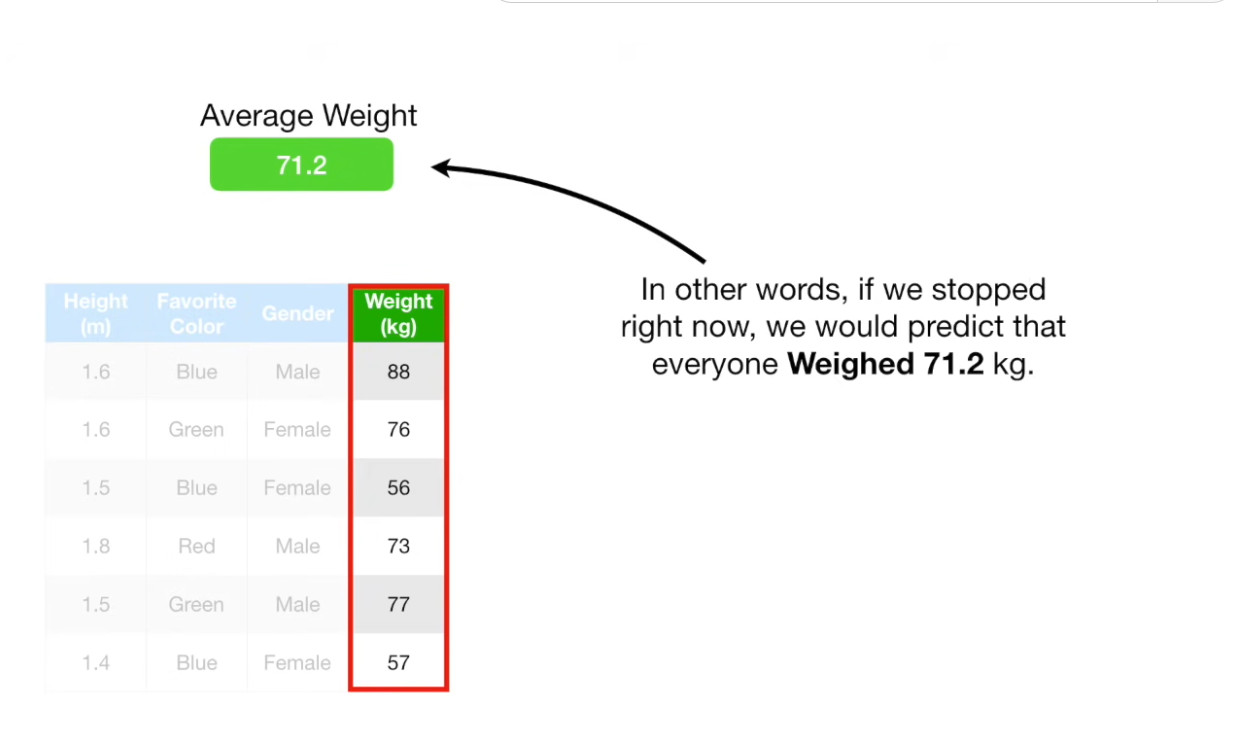

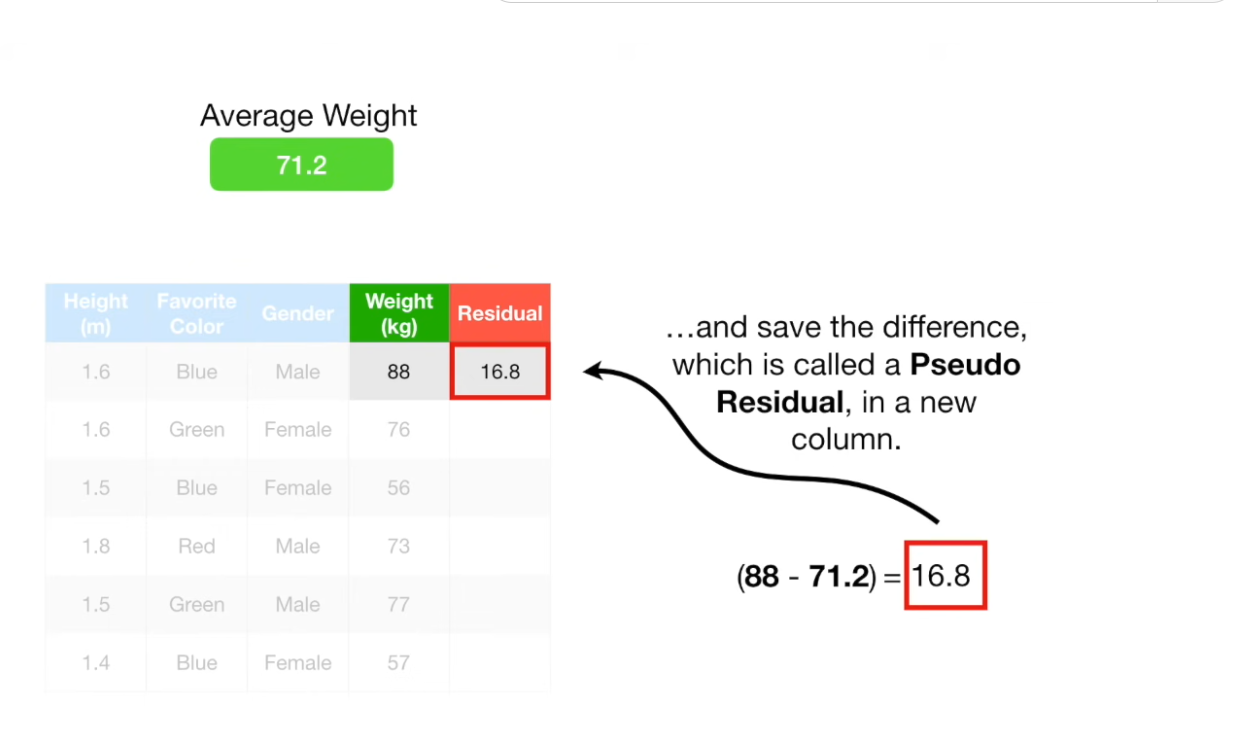

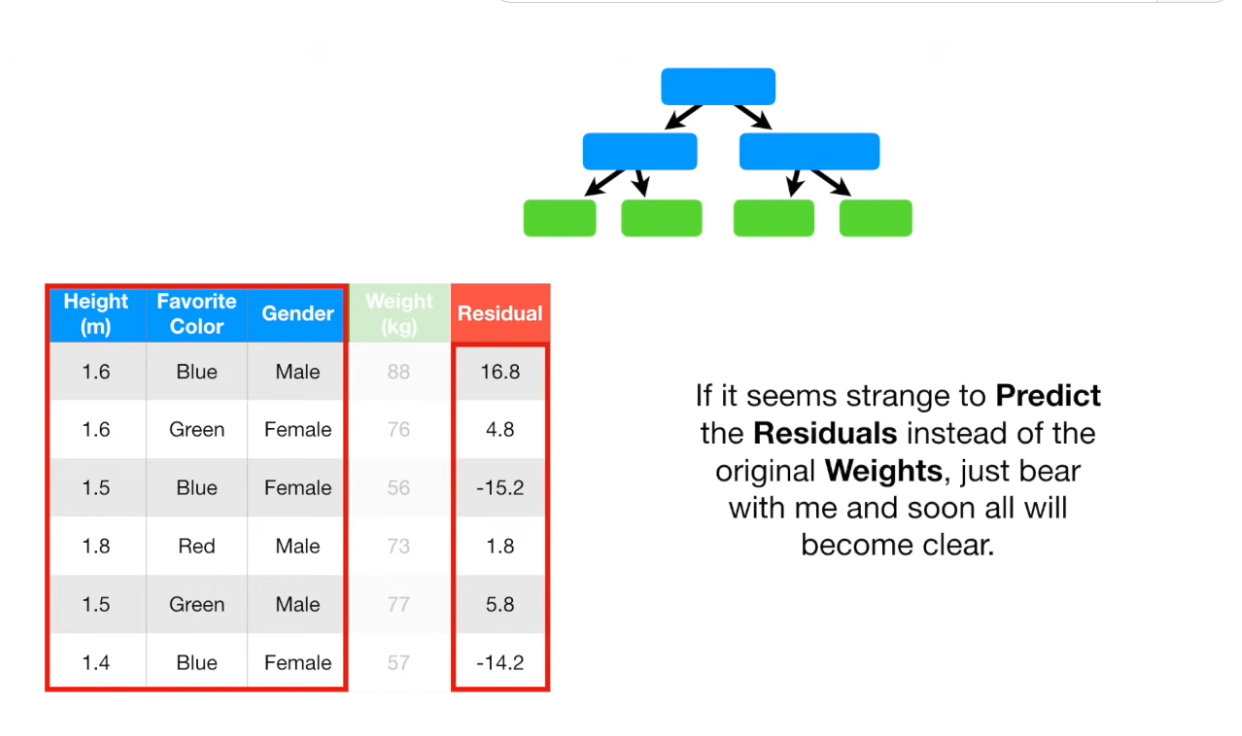

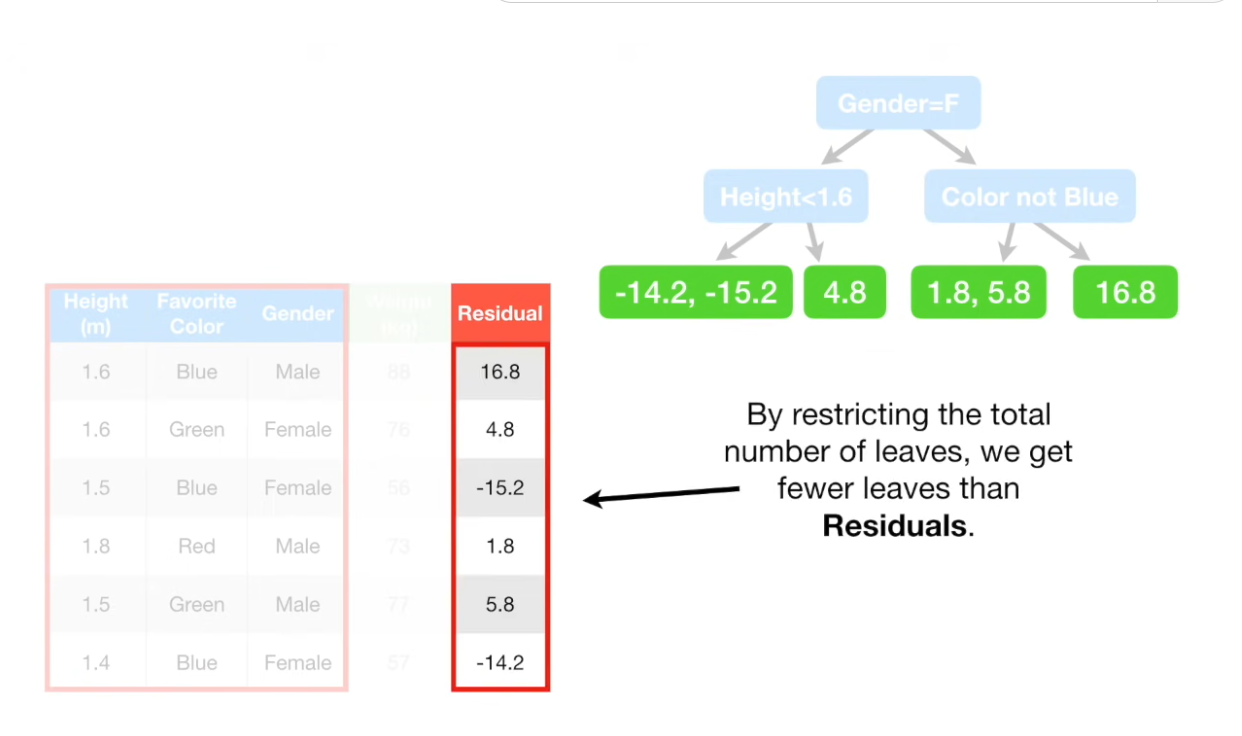

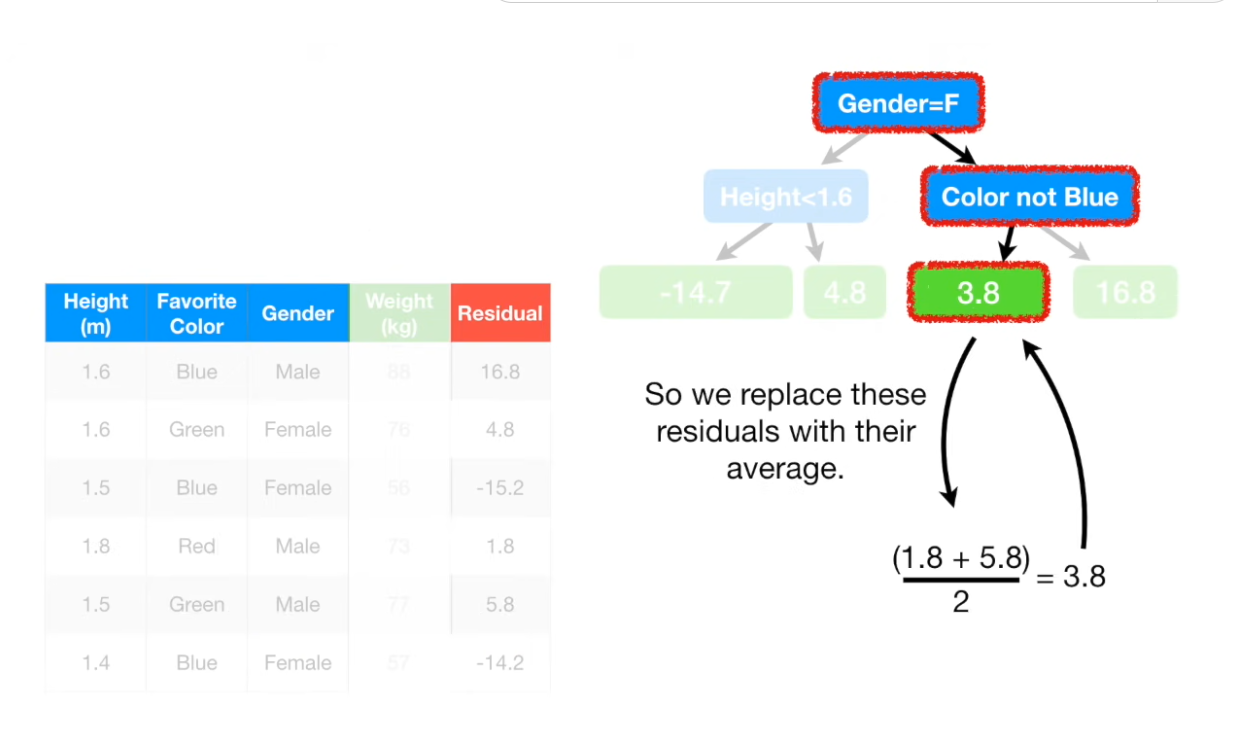

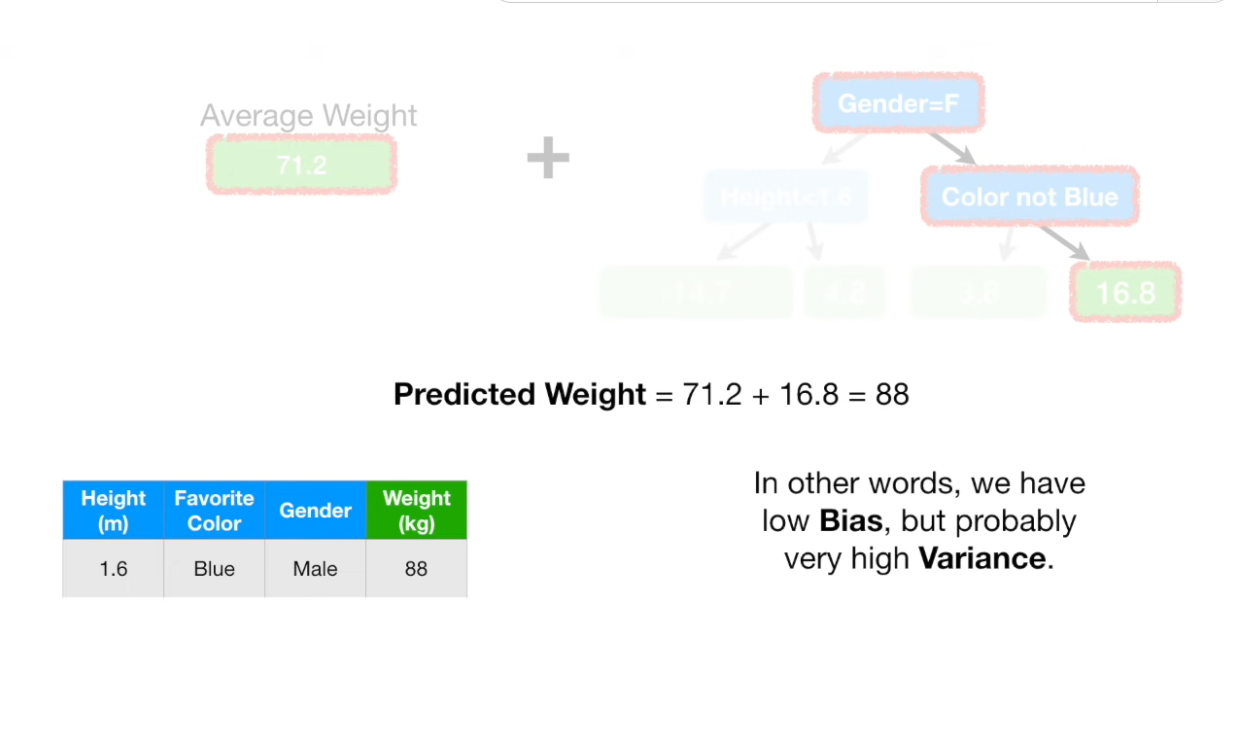

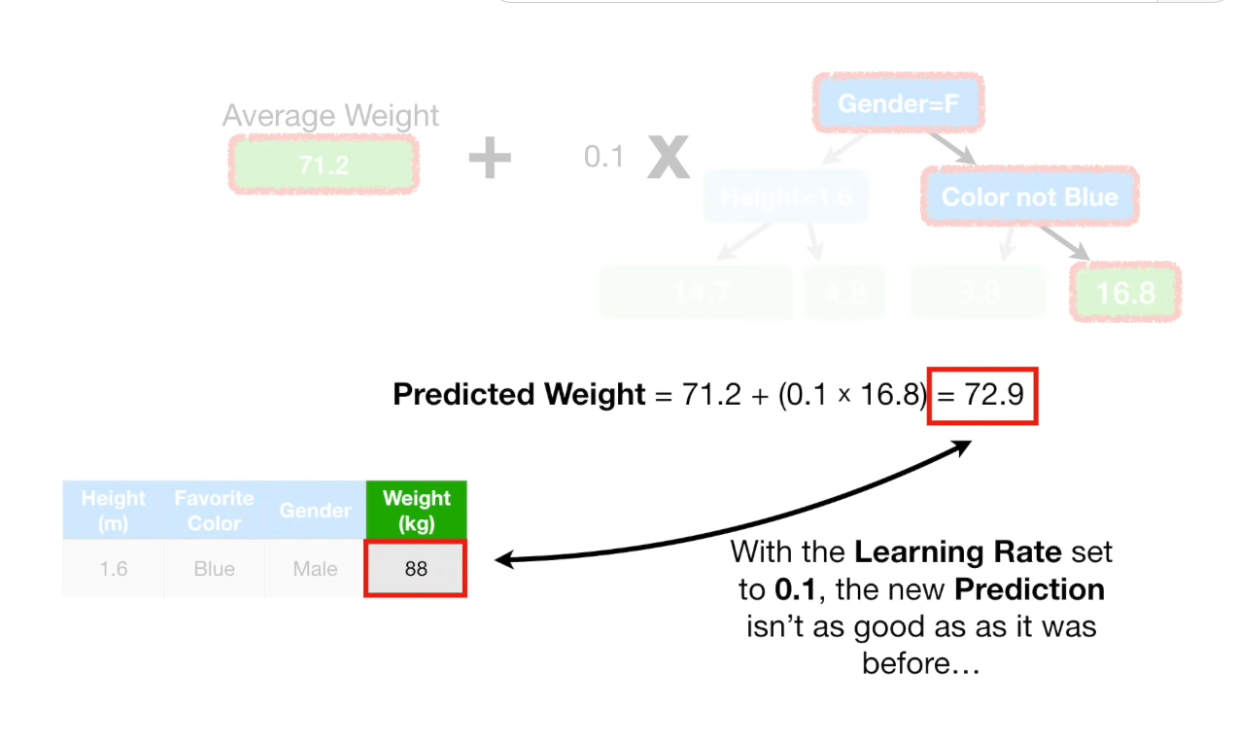

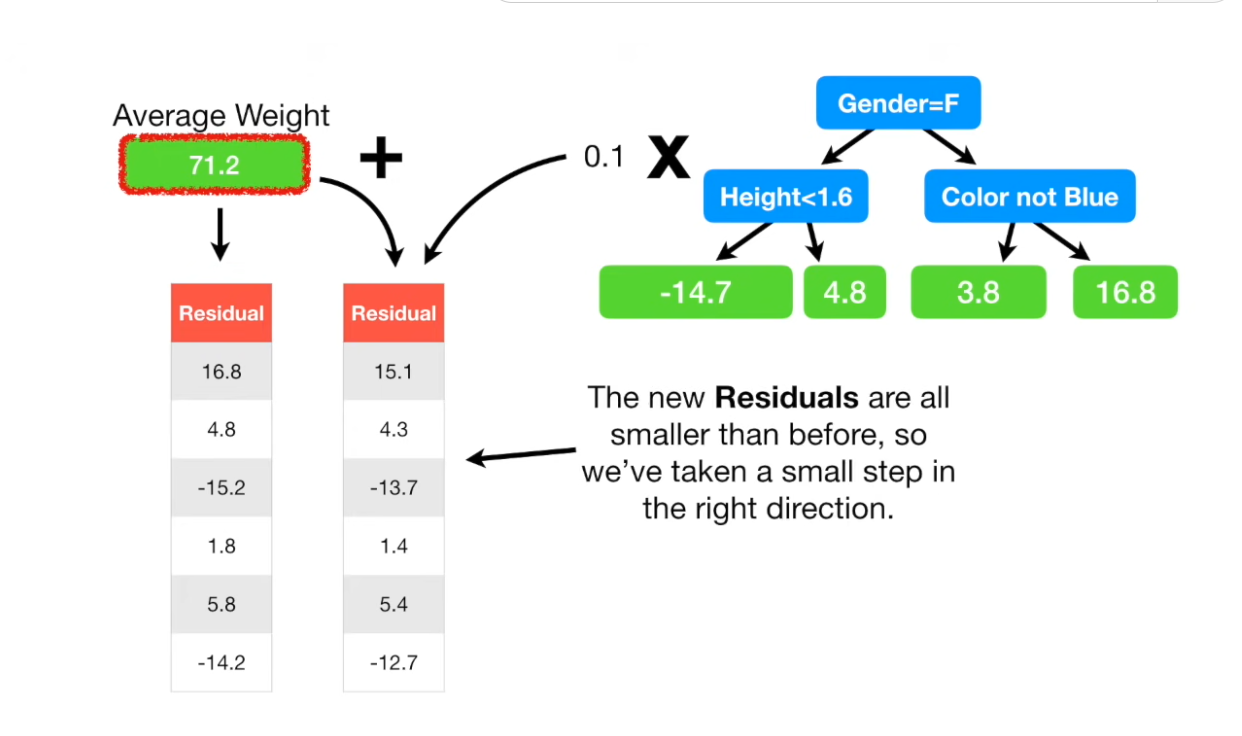

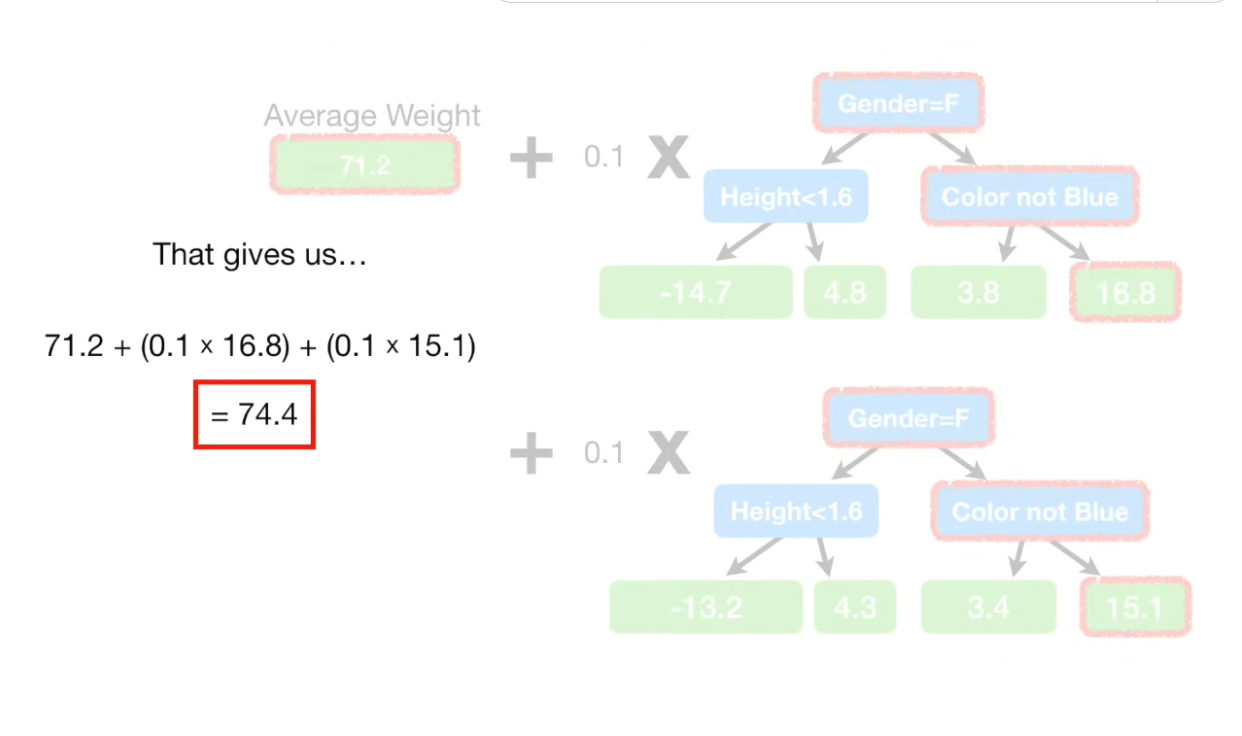

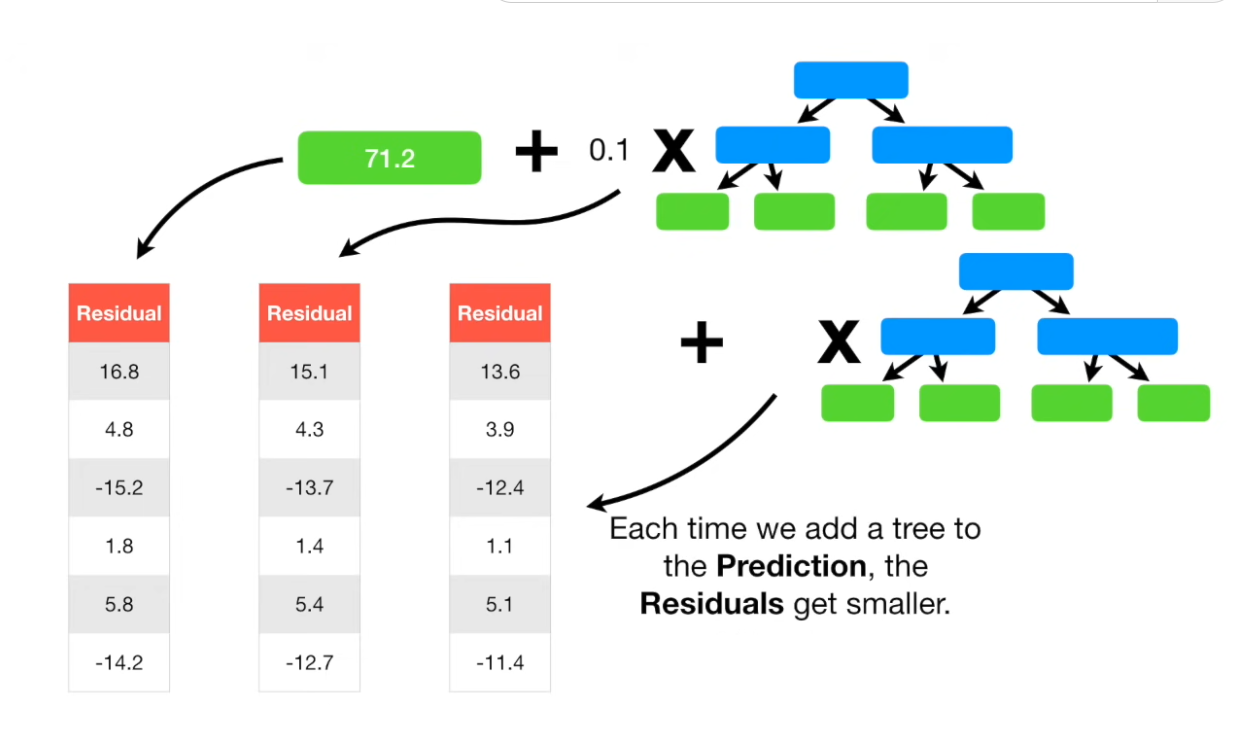

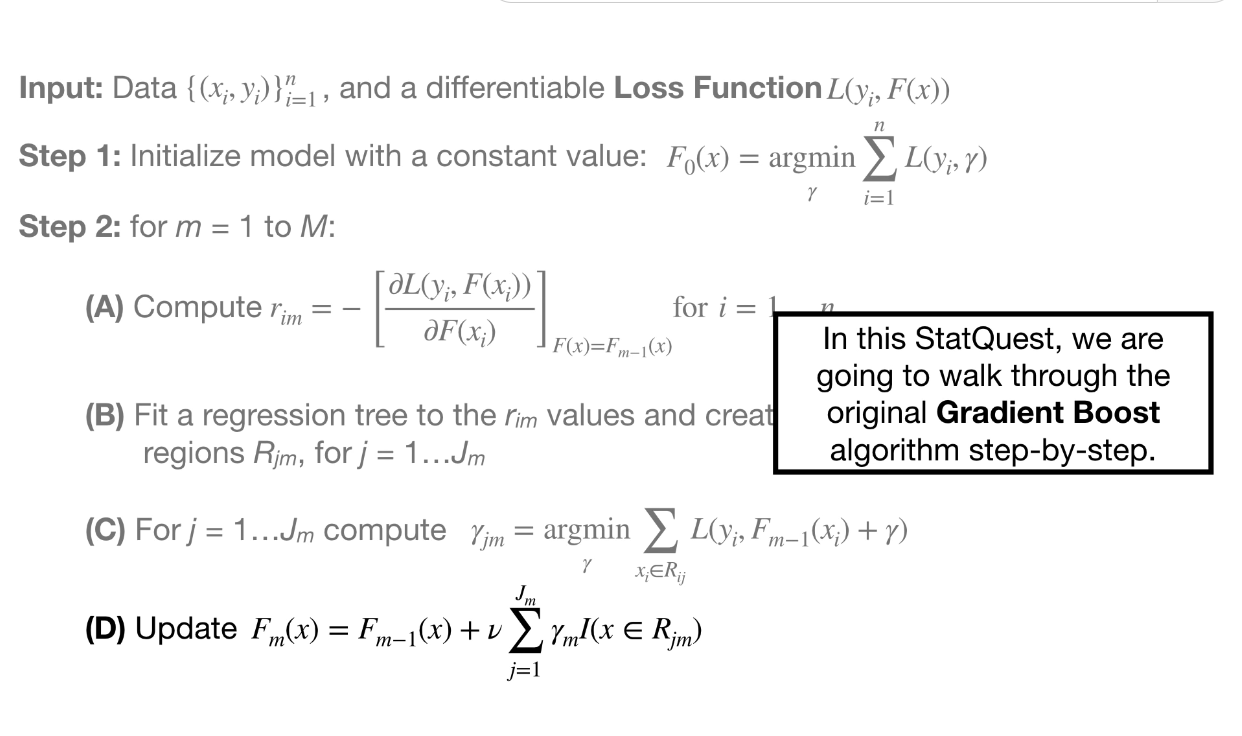

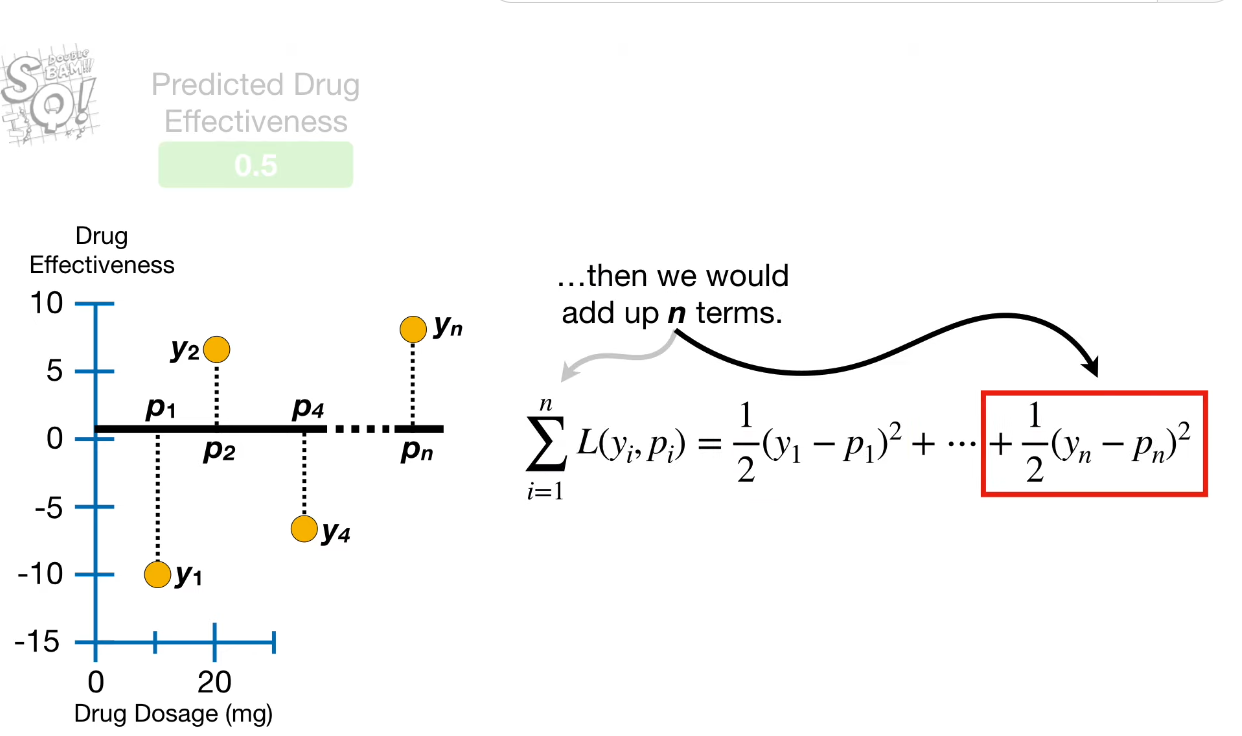

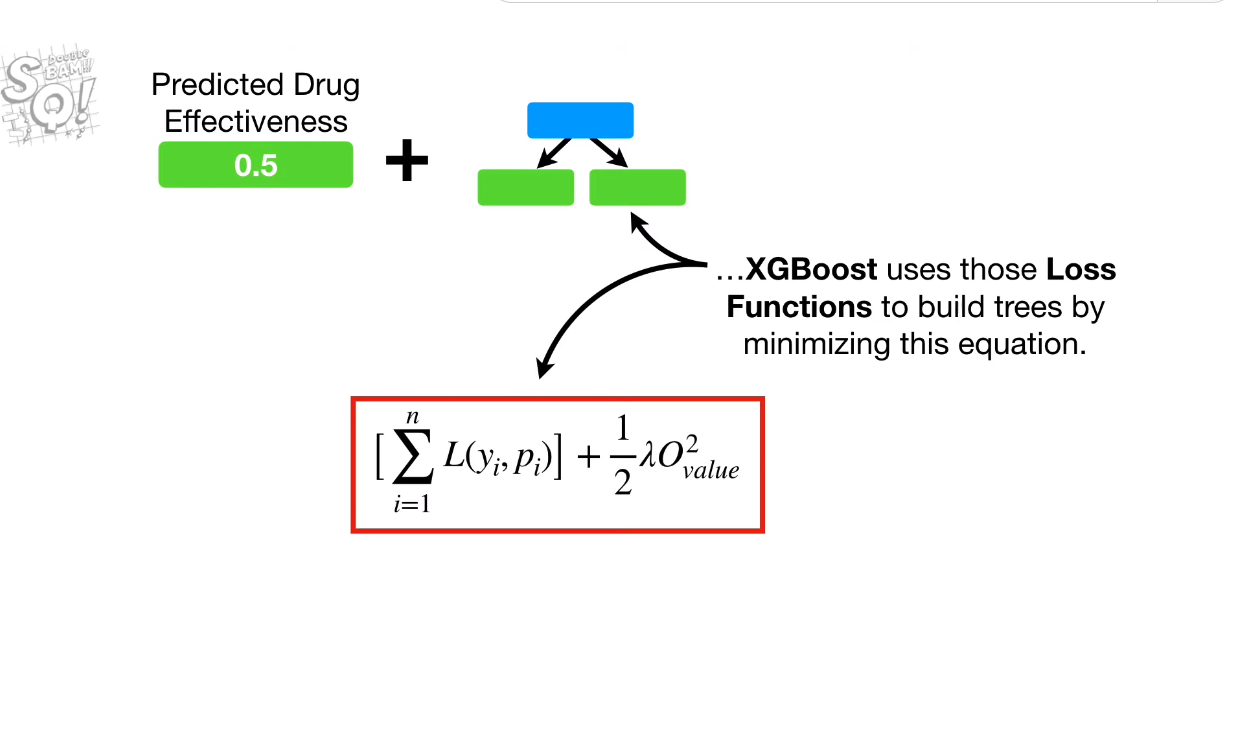

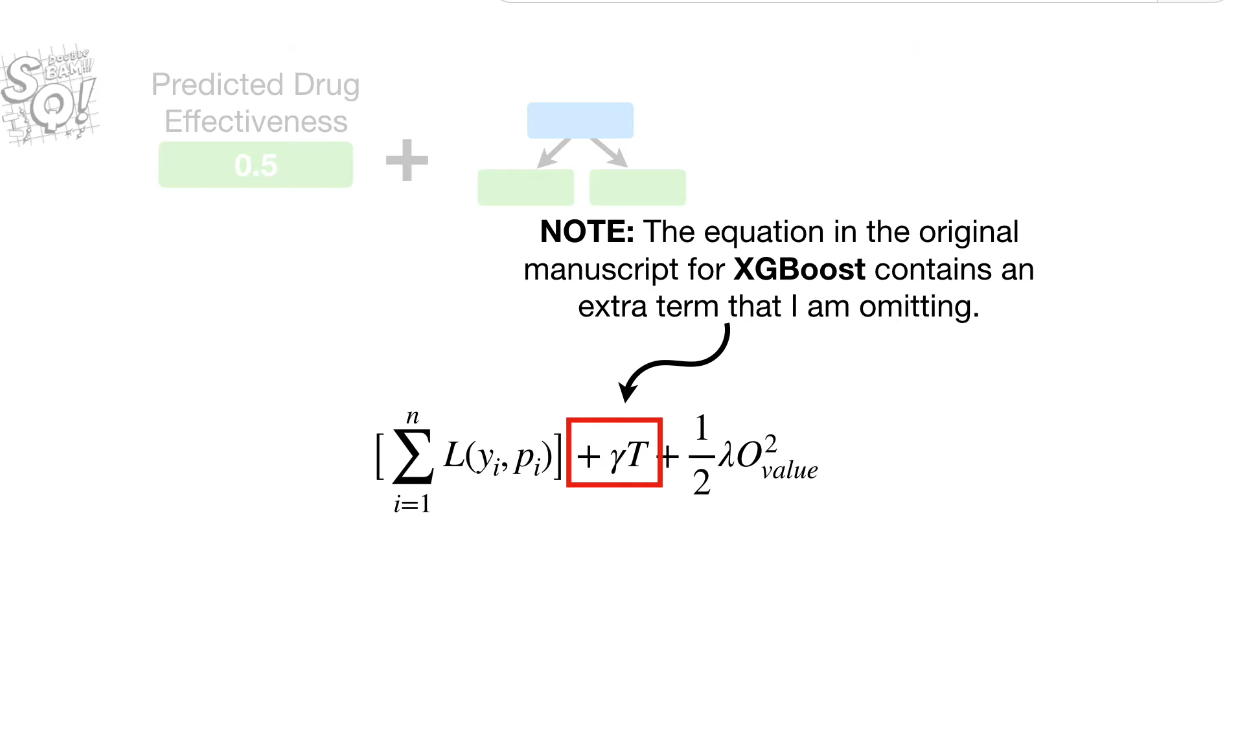

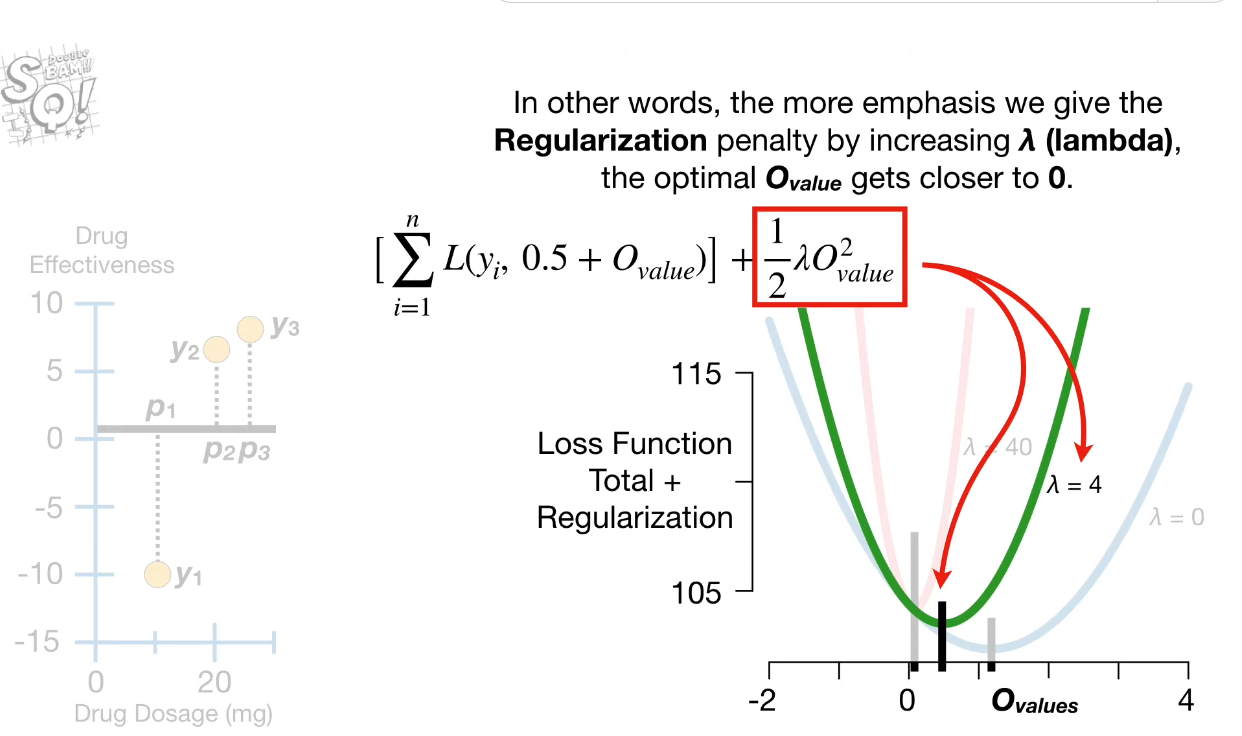

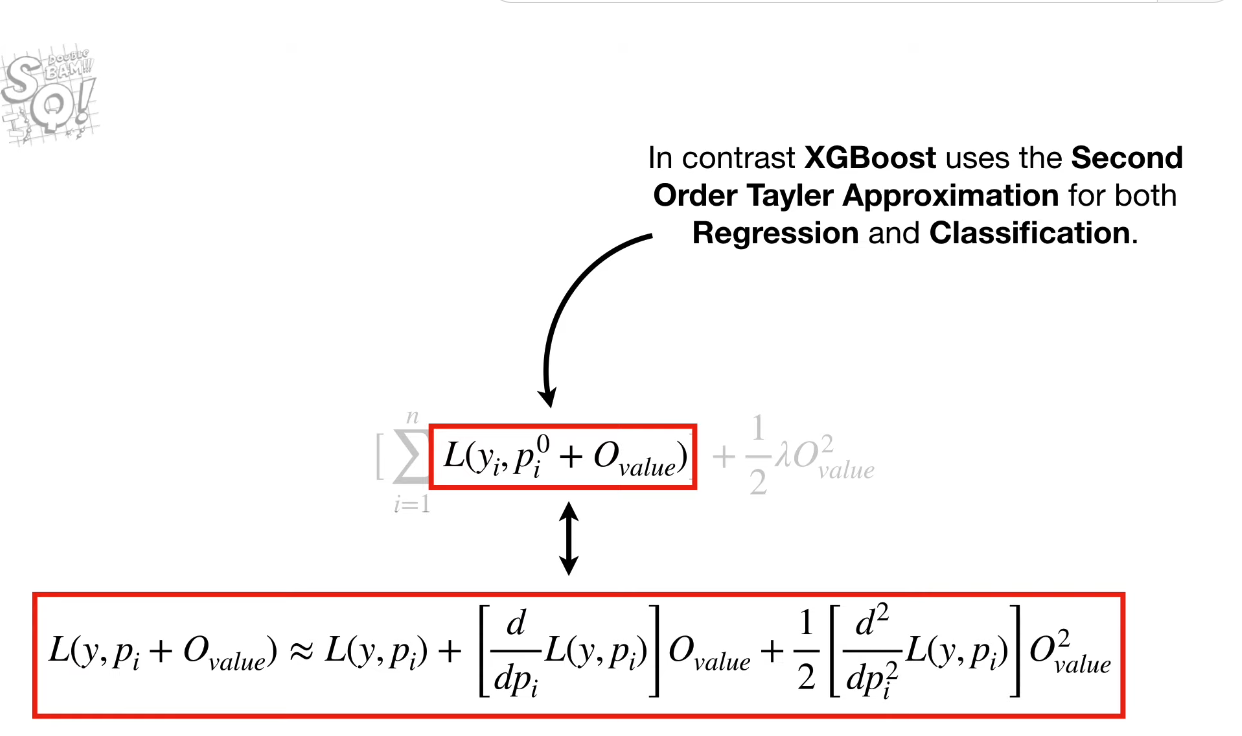

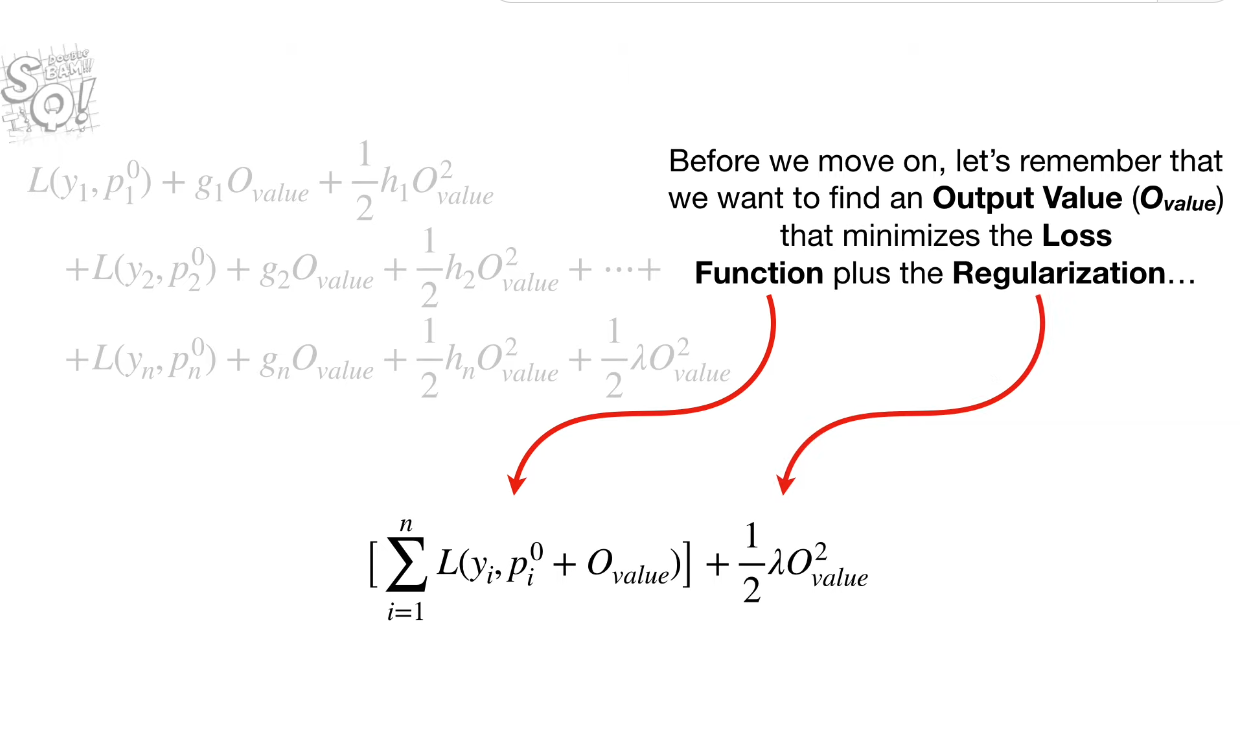

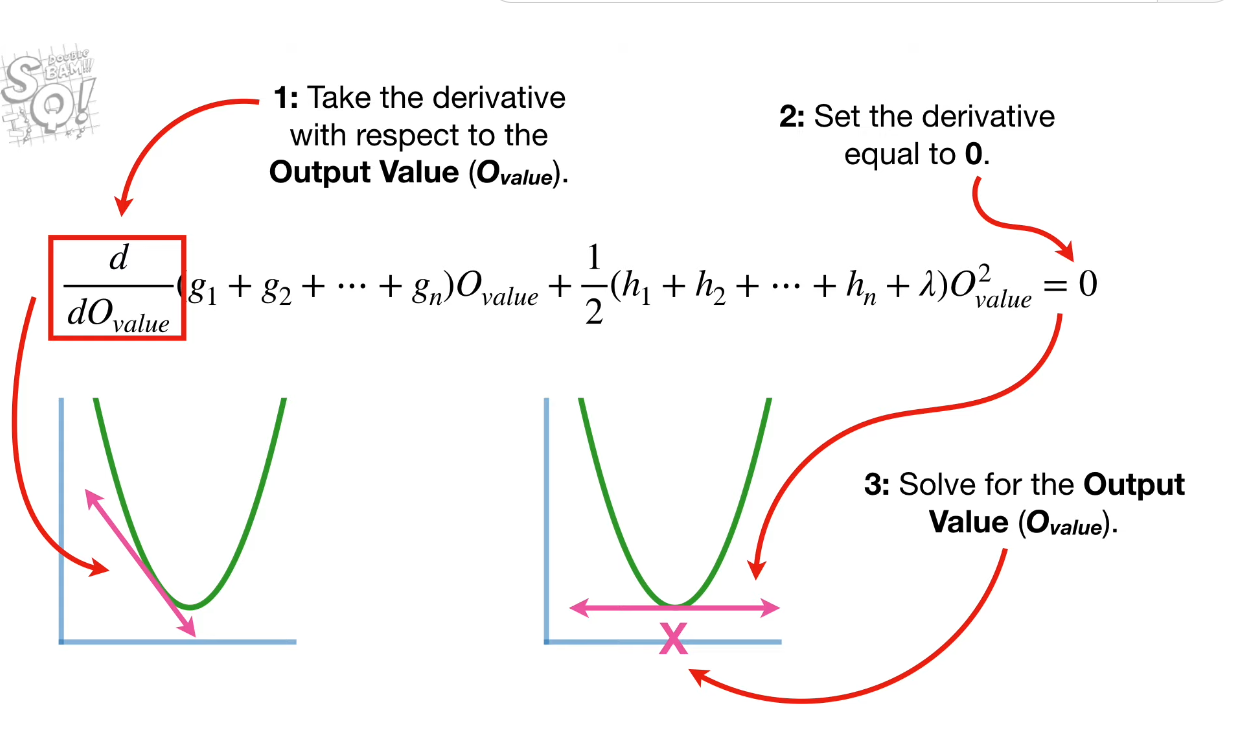

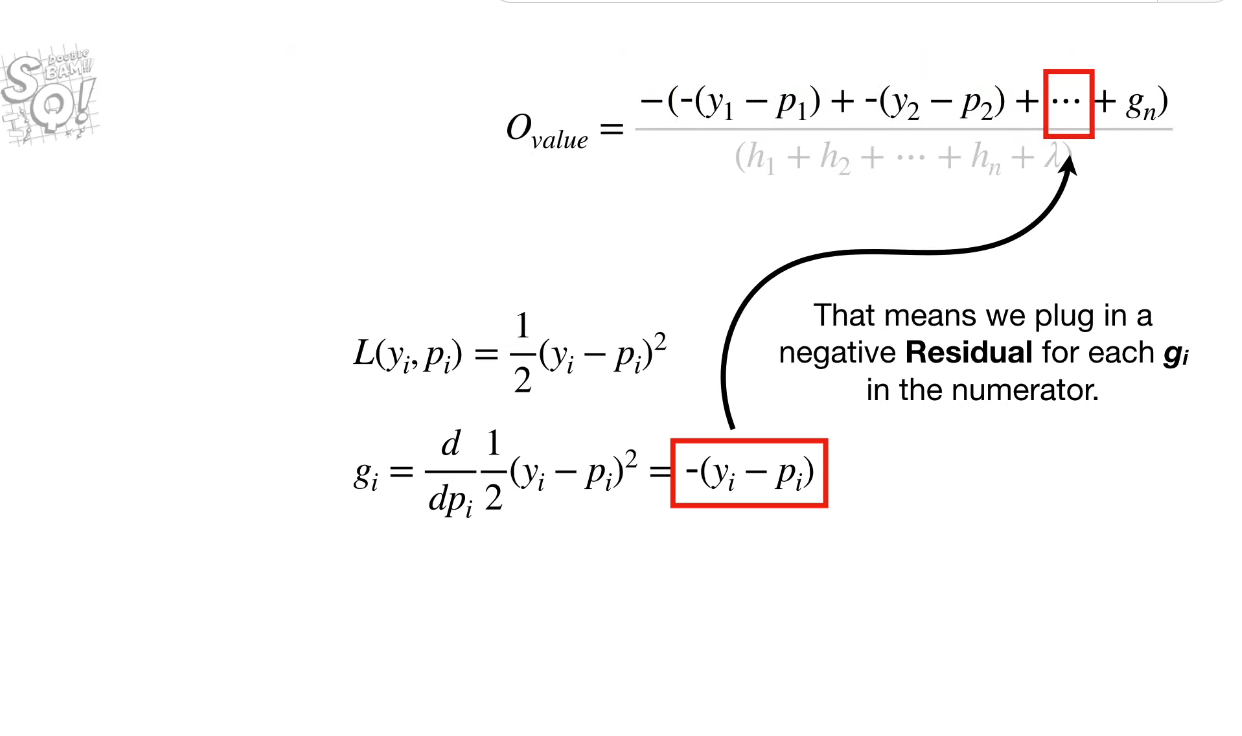

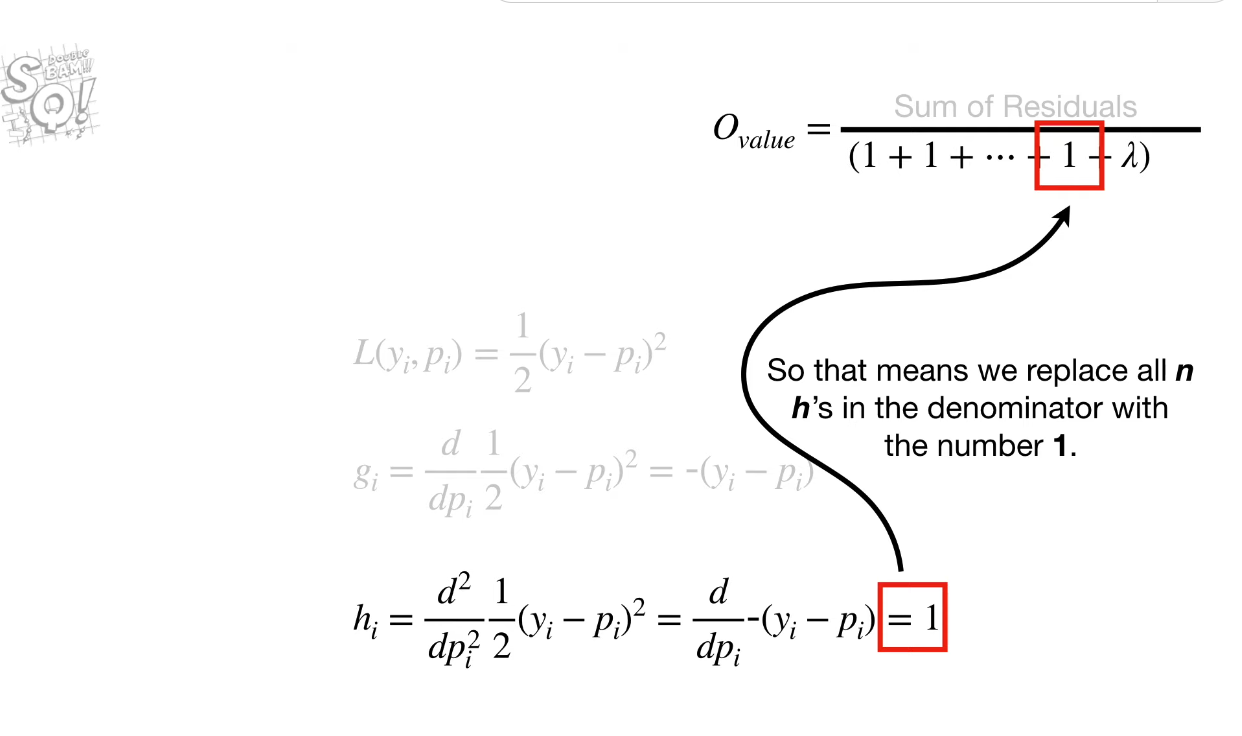

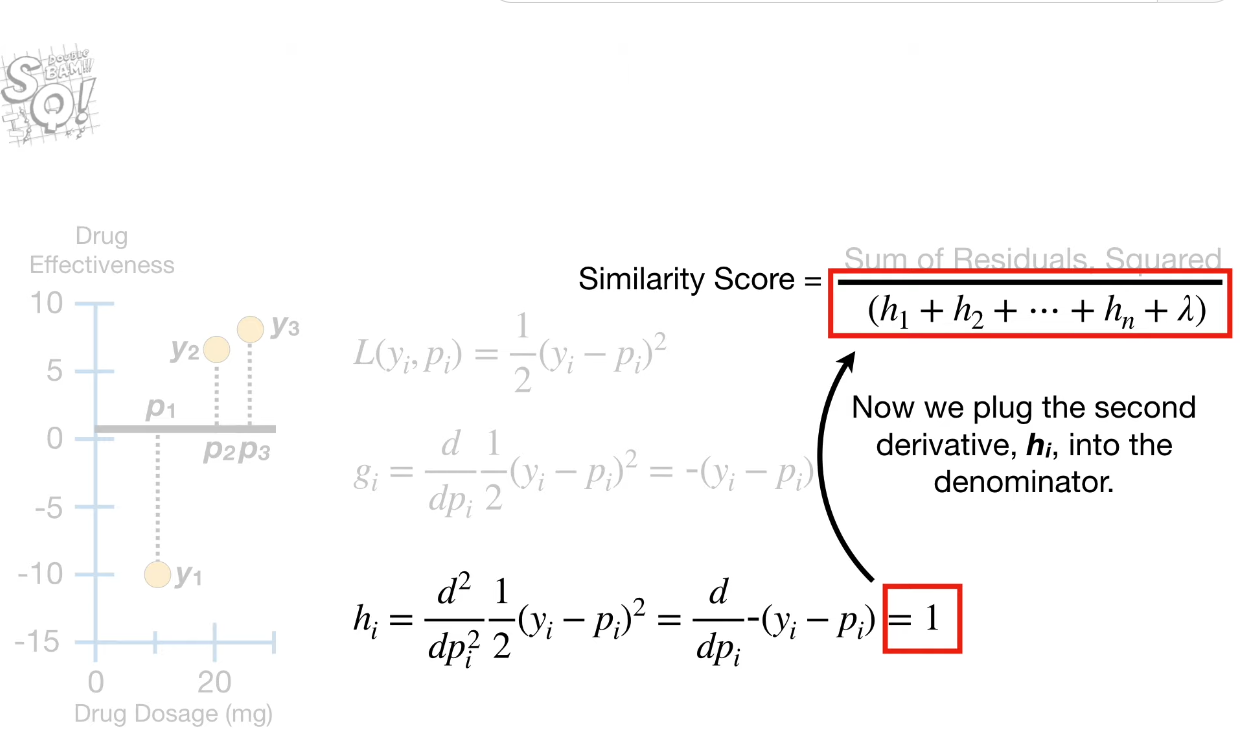

## Gradient Boosting Algorithms

## There are many algorithms that each perform slightly different versions of gradient boosting. When the gradient boosting approach was first invented, the algorithms were not very performant, but that changed with the AdaBoost algorithm: the first algorithm that could adapt to weak learners.

##Gradient boosting algorithms are among the most performant machine learning tools on the market. After AdaBoost, a long list of slightly different boosting algorithms has been added to the literature, including XGBoost, LightGBM, LPBoost, BrownBoost,MadaBoost, LogitBoost, and TotalBoost. There are still many contributions being made to improve on gradient boosting theory.

## We will focus on two algorithms here: XGBoost and LightGBM.

##XGBoost is one of the most used machine learning algorithms. XGBoost is a quick way to get good performances. As it is easy to use and very performant, it is the first go-to algorithm for many ML practitioners.


##LightGBM is another gradient boosting algorithm that is important to know. For the moment, it is a bit less widespread than XGBoost, but it is seriously gaining in popularity. The expected advantage of LightGBM over XGBoost is a gain in speed and memory use. In this chapter, you will discover the implementations of both of those gradient boosting algorithms.

In [ ]:
# Importing the data

import pandas as pd

url = 'https://raw.githubusercontent.com/kboroz/TimeSeriesPredictionWS2023/main/Metro_Interstate_Traffic_Volume.csv'
data = pd.read_csv(url)


In [ ]:
# Applying the same feature engineering as done previously for the kNN model

data['year'] = data['date_time'].apply(lambda x: int(x[:4]))
data['month'] = data['date_time'].apply(lambda x: int(x[5:7]))
data['weekday'] = pd.to_datetime(data['date_time']).apply(lambda x: x.weekday())
data['hour'] = pd.to_datetime(data['date_time']).apply(lambda x: x.hour)
data['isholiday'] = (data['holiday'] == 'None').apply(float)


In [ ]:
# Applying the default XGBoost model

# Create objects X and y
X = data[['year', 'month', 'weekday', 'hour', 'isholiday']]
y = data['traffic_volume']

# Create Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=12345, shuffle=False)

from xgboost import XGBRegressor
my_xgb = XGBRegressor()
my_xgb.fit(X_train, y_train)

xgb_fcst = my_xgb.predict(X_test)

from sklearn.metrics import r2_score
print(r2_score(list(y_test), list(xgb_fcst)))

0.972561311152506


In [ ]:
# Applying the default LightGBM model

from lightgbm import LGBMRegressor
my_lgbm = LGBMRegressor()
my_lgbm.fit(X_train, y_train)

lgbm_fcst = my_lgbm.predict(X_test)

print(r2_score(list(y_test), list(lgbm_fcst)))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data points in the train set: 48104, number of used features: 5
[LightGBM] [Info] Start training from score 3259.693685
0.9720890529886204


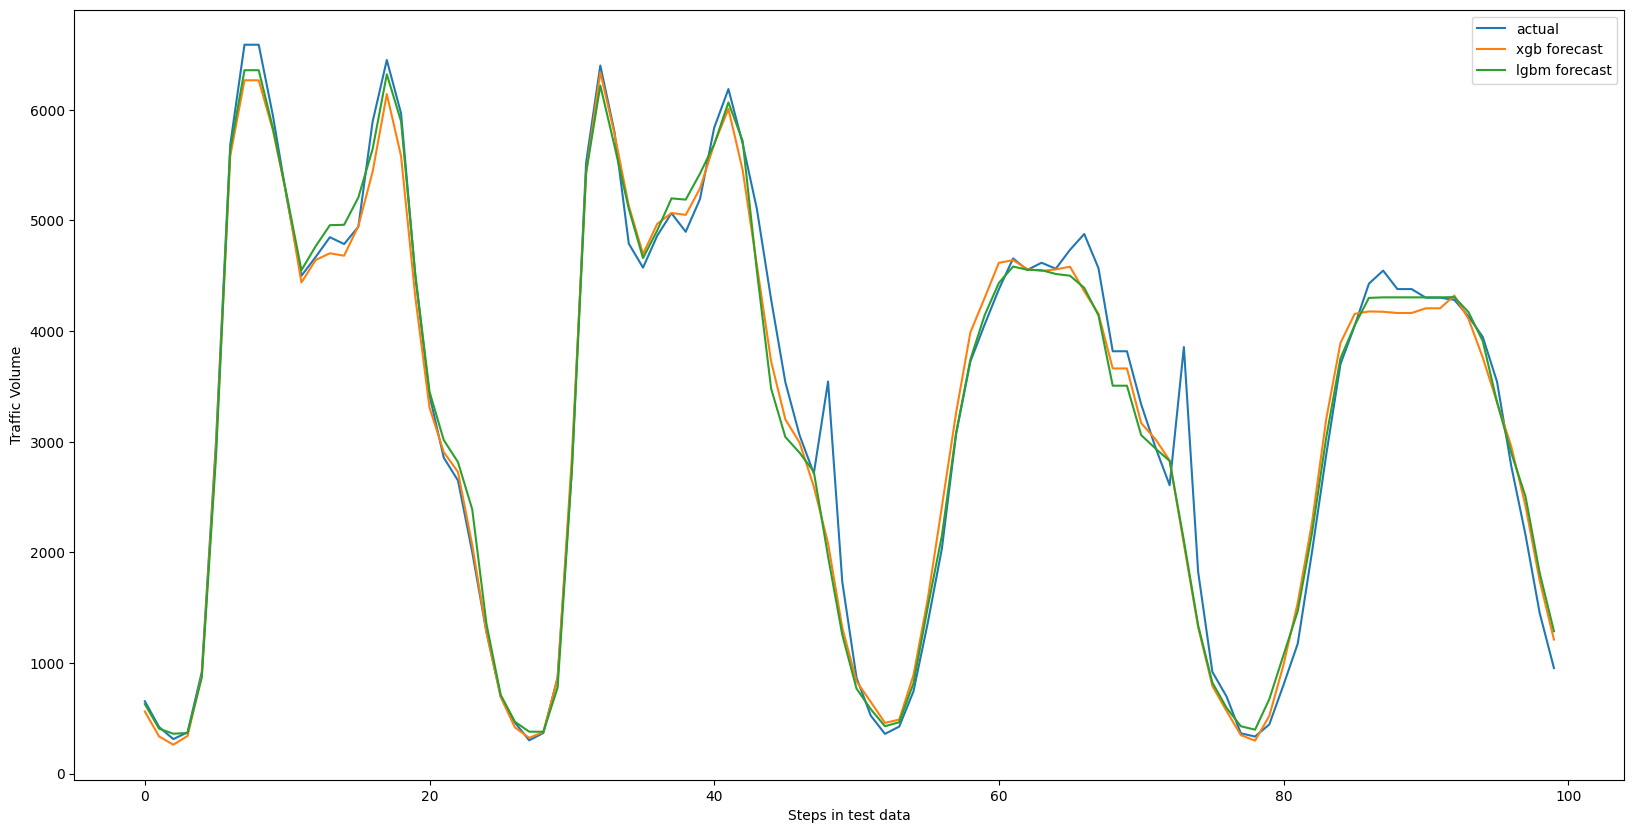

In [ ]:
# Create a graph to compare the XGBoost and LightGBM forecast to the actuals

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(list(y_test))
plt.plot(list(xgb_fcst))
plt.plot(list(lgbm_fcst))
plt.legend(['actual', 'xgb forecast', 'lgbm forecast'])
plt.ylabel('Traffic Volume')
plt.xlabel('Steps in test data')
plt.show()

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.8 MB/s eta 0:00:00


In [ ]:
# Applying a Bayesian Optimization to the xgboost

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import random
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

random.seed(0)

xgb_opt = BayesSearchCV(
    XGBRegressor(),
    {
        'learning_rate': (10e-6, 1.0, 'log-uniform'),
        'max_depth': Integer(0, 50, 'uniform'),
        'n_estimators' : (10, 1000, 'log-uniform'),
    },
    n_iter=10,
    cv=3
)

xgb_opt.fit(X_train, y_train)
xgb_tuned_fcst = xgb_opt.best_estimator_.predict(X_test)
r2_score(list(y_test), list(xgb_tuned_fcst))


0.9689801483586135

In [ ]:
# Applying a Bayesian Optimization to the LightGBM

random.seed(0)
lgbm_opt = BayesSearchCV(
    LGBMRegressor(),
    {
        'learning_rate': (10e-6, 1.0, 'log-uniform'),
        'max_depth': Integer(-1, 50, 'uniform'),
        'n_estimators' : (10, 1000, 'log-uniform'),
    },
    n_iter=10,
    cv=3
)

lgbm_opt.fit(X_train, y_train)

lgbm_tuned_fcst = lgbm_opt.best_estimator_.predict(X_test)
r2_score(list(y_test), list(lgbm_tuned_fcst))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51
[LightGBM] [Info] Number of data points in the train set: 32069, number of used features: 5
[LightGBM] [Info] Start training from score 3257.167888
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set n

0.9703189345776473

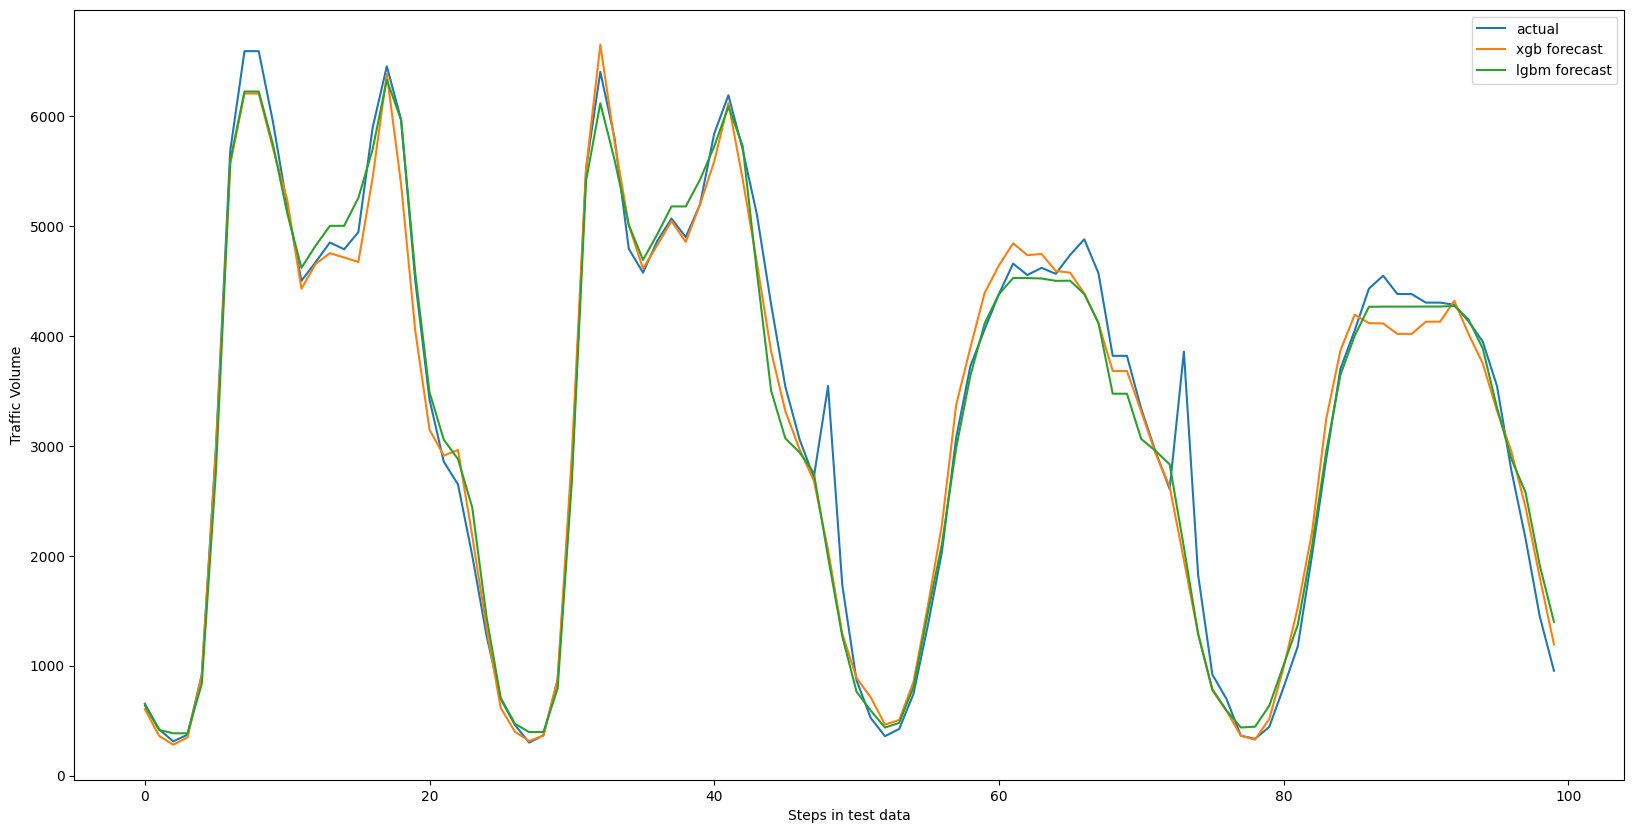

In [ ]:
# Plotting the two tuned models

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(list(y_test))
plt.plot(list(xgb_tuned_fcst))
plt.plot(list(lgbm_tuned_fcst))
plt.legend(['actual', 'xgb forecast', 'lgbm forecast'])
plt.ylabel('Traffic Volume')
plt.xlabel('Steps in test data')
plt.show()